# Machine learning model with the fMRI data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
import numpy as np
import nilearn as nl
from nilearn import datasets
from nilearn import plotting
from nilearn import connectome

# Load the time series

In [2]:
# let's load the dataset created

with np.load('fMRI_time_series.npz', allow_pickle=True) as npz_file:
    data = dict(npz_file.items())
    
print('Data loaded')
print('It is a dictionary with keys:', list(data.keys()))

X = data['matrix']
print('X shape:', X.shape)

y = data['targets']
print('y shape:', y.shape)

Data loaded
It is a dictionary with keys: ['matrix', 'targets']
X shape: (870,)
y shape: (870,)


In [3]:
from sklearn.model_selection import train_test_split

# Create X and y arrays for my analysis

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 9)

print('X train:', X_tr.shape)
print('X test:', X_te.shape)
print('y train:', y_tr.shape)
print('y test:', y_te.shape)

print('ASD in the test data:', (y_te == 1).sum())
print('Control in the test data:', (y_te == 2).sum())

X train: (696,)
X test: (174,)
y train: (696,)
y test: (174,)
ASD in the test data: 81
Control in the test data: 93


In [4]:
# Function to plot my confusion matrix
# code taken at https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Create a baseline to evaluate my models

In [5]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it
dummy.fit(None, y_tr)

# Compute test accuracy
baseline_accuracy = dummy.score(None, y_te)
print('Accuracy: {:.2f}'.format(baseline_accuracy))

# Create a dict to store the results of my models
models_acc = dict()
models_acc['baseline'] = 100*baseline_accuracy

Accuracy: 0.53


## LinearSVC model

* Connectivity : type of matrix connectivity (https://nilearn.github.io/auto_examples/05_advanced/plot_age_group_prediction_cross_val.html#sphx-glr-auto-examples-05-advanced-plot-age-group-prediction-cross-val-py)
* Standard Scaler 
* C

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
# import warnings filter
from warnings import simplefilter
# ignore all fuature warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nilearn.connectome import ConnectivityMeasure


linear_svc = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True)),
    ('scaler', StandardScaler()),
    ('l_svc', LinearSVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

param_grid = {
    'connectivity__kind':['correlation', 'partial correlation', 'tangent'],
    'scaler': [None, StandardScaler()],
    'l_svc__C':[0.0001, 0.001, 0.01, 0.05, 1, 10],
}

lin_svc = GridSearchCV(linear_svc, param_grid, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

lin_svc.fit(X_tr, y_tr);

lin_svc_results = pd.DataFrame({
    'connectivity': lin_svc.cv_results_['param_connectivity__kind'],
    'scale': lin_svc.cv_results_['param_scaler'],
    'C': lin_svc.cv_results_['param_l_svc__C'],
    'mean_tr': lin_svc.cv_results_['mean_train_score'],
    'mean_te': lin_svc.cv_results_['mean_test_score'],
    'std_te': lin_svc.cv_results_['std_test_score']
})

# # Plot the validation curves
# plt.semilogx(lin_svc_results['C'], lin_svc_results['mean_tr'], label='train curve')
# plt.semilogx(lin_svc_results['C'], lin_svc_results['mean_te'], label='test curve')

# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.1min finished
C:\Users\xavier\anaconda3\envs\exts-ml\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
lin_svc_results.sort_values(by='mean_te', ascending=False).head(5)

,connectivity,scale,C,mean_tr,mean_te,std_te
7,correlation,"StandardScaler(copy=True, with_mean=True, with...",0.05,1.000000,0.677143,0.066762
8,correlation,None,1,1.000000,0.671429,0.071142
10,correlation,None,10,1.000000,0.668571,0.057428
5,correlation,"StandardScaler(copy=True, with_mean=True, with...",0.01,1.000000,0.668571,0.069635
28,tangent,None,0.01,0.950479,0.668571,0.055255


Test accuracy: 72.99%
              precision    recall  f1-score   support

           1       0.70      0.73      0.72        81
           2       0.76      0.73      0.74        93

   micro avg       0.73      0.73      0.73       174
   macro avg       0.73      0.73      0.73       174
weighted avg       0.73      0.73      0.73       174



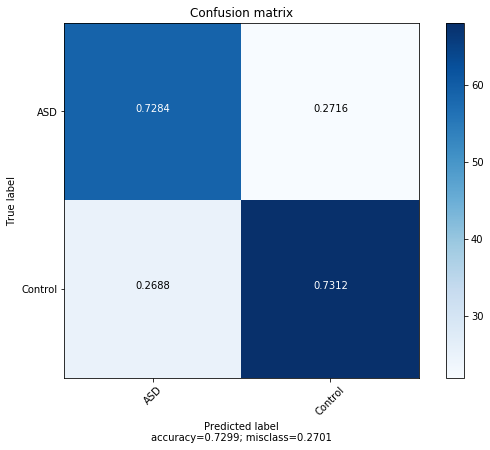

Best score: 0.6771428571428572
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='correlation', vectorize=True)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('l_svc', LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=9, tol=0.0001,
     verbose=0))])
Best params: {'connectivity__kind': 'correlation', 'l_svc__C': 0.05, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [8]:
print('Test accuracy: {:.2f}%'.format(100*lin_svc.score(X_te, y_te)))

y_pred = lin_svc.predict(X_te)

report = classification_report(y_true=y_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', lin_svc.best_score_)
print('Best estimator:', lin_svc.best_estimator_)
print('Best params:', lin_svc.best_params_)

In [9]:
# Refine
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
# import warnings filter
from warnings import simplefilter
# ignore all fuature warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nilearn.connectome import ConnectivityMeasure


linear_svc = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True, kind='correlation')),
    ('scaler', StandardScaler()),
    ('l_svc', LinearSVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

param_grid = {
    'l_svc__C':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
}

lin_svc = GridSearchCV(linear_svc, param_grid, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

lin_svc.fit(X_tr, y_tr);

lin_svc_results = pd.DataFrame({
#     'connectivity': lin_svc.cv_results_['param_connectivity__kind'],
#     'scale': lin_svc.cv_results_['param_scaler'],
    'C': lin_svc.cv_results_['param_l_svc__C'],
    'mean_tr': lin_svc.cv_results_['mean_train_score'],
    'mean_te': lin_svc.cv_results_['mean_test_score'],
    'std_te': lin_svc.cv_results_['std_test_score']
})

# # Plot the validation curves
# plt.semilogx(lin_svc_results['C'], lin_svc_results['mean_tr'], label='train curve')
# plt.semilogx(lin_svc_results['C'], lin_svc_results['mean_te'], label='test curve')

# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Test accuracy: 72.99%
              precision    recall  f1-score   support

           1       0.70      0.73      0.72        81
           2       0.76      0.73      0.74        93

   micro avg       0.73      0.73      0.73       174
   macro avg       0.73      0.73      0.73       174
weighted avg       0.73      0.73      0.73       174



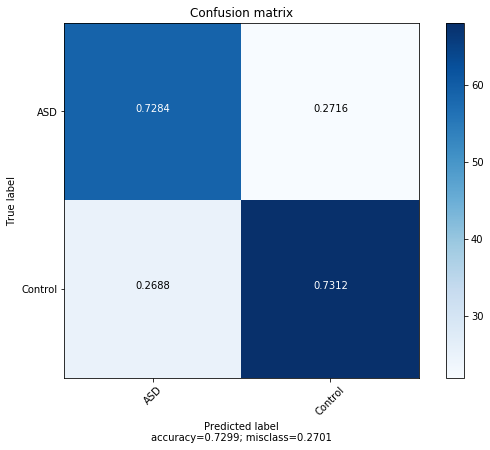

Best score: 0.6771428571428572
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='correlation', vectorize=True)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('l_svc', LinearSVC(C=0.04, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=9, tol=0.0001,
     verbose=0))])
Best params: {'l_svc__C': 0.04}


In [10]:
print('Test accuracy: {:.2f}%'.format(100*lin_svc.score(X_te, y_te)))
models_acc['Linear SVC'] = 100*lin_svc.score(X_te, y_te)

y_pred = lin_svc.predict(X_te)

report = classification_report(y_true=y_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', lin_svc.best_score_)
print('Best estimator:', lin_svc.best_estimator_)
print('Best params:', lin_svc.best_params_)

# Try with the SVC estimator

* Connectivity : type of matrix connectivity (https://nilearn.github.io/auto_examples/05_advanced/plot_age_group_prediction_cross_val.html#sphx-glr-auto-examples-05-advanced-plot-age-group-prediction-cross-val-py)
* Standard Scaler 
* Kernel : rbf/linear
* C
* Gamma

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings

SVC = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True)),
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=3, random_state=0)

param_grid = {
    'connectivity__kind':['correlation', 'tangent'],
    'scaler': [None, StandardScaler()],
    'svc__C':[0.01, 0.05, 1, 10, 20, 30, 40, 50, 100],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.05, 1, 10, 50, 100],
    'svc__kernel':['rbf', 'linear']
}

svc_gdcv = GridSearchCV(SVC, param_grid, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

svc_gdcv.fit(X_tr, y_tr);

svc_results = pd.DataFrame({
    'connectivity': svc_gdcv.cv_results_['param_connectivity__kind'],
    'scale': svc_gdcv.cv_results_['param_scaler'],
    'kernel':svc_gdcv.cv_results_['param_svc__kernel'],
    'C': svc_gdcv.cv_results_['param_svc__C'],
    'gamma': svc_gdcv.cv_results_['param_svc__gamma'],
    'mean_tr': svc_gdcv.cv_results_['mean_train_score'],
    'mean_te': svc_gdcv.cv_results_['mean_test_score'],
    'std_te': svc_gdcv.cv_results_['std_test_score']
})

svc_results.sort_values(by='mean_te', ascending=False).head(5)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 43.4min finished


,connectivity,scale,kernel,C,gamma,mean_tr,mean_te,std_te
416,tangent,None,rbf,100,0.0001,0.879659,0.652381,0.047140
338,tangent,None,rbf,10,0.001,0.877529,0.647619,0.052597
326,tangent,None,rbf,1,0.05,0.998403,0.638095,0.035635
354,tangent,None,rbf,20,0.001,0.944089,0.638095,0.006734
169,correlation,"StandardScaler(copy=True, with_mean=True, with...",linear,0.05,1,1.000000,0.633333,0.037495


Test accuracy: 71.26%
              precision    recall  f1-score   support

           1       0.75      0.58      0.65        81
           2       0.69      0.83      0.75        93

   micro avg       0.71      0.71      0.71       174
   macro avg       0.72      0.70      0.70       174
weighted avg       0.72      0.71      0.71       174



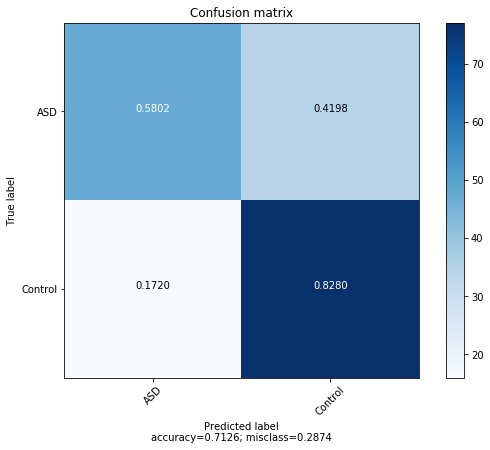

Best score: 0.6523809523809524
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('scaler', None), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=9, shrinking=True,
  tol=0.001, verbose=False))])
Best params: {'connectivity__kind': 'tangent', 'scaler': None, 'svc__C': 100, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [12]:
print('Test accuracy: {:.2f}%'.format(100*svc_gdcv.score(X_te, y_te)))

y_pred = svc_gdcv.predict(X_te)

report = classification_report(y_true=y_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', svc_gdcv.best_score_)
print('Best estimator:', svc_gdcv.best_estimator_)
print('Best params:', svc_gdcv.best_params_)

## Refine my search 

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings

SVC_ref = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True, 
                                         kind='tangent')),
#     ('scaler', StandardScaler()),
    ('svc', SVC(random_state=9, 
               kernel='rbf'))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

grid_refined = {
#     'connectivity__kind':['correlation', 'partial correlation', 'tangent'],
#     'scaler': [None, StandardScaler()],
    'svc__C':np.arange(100, 150, 5),
    'svc__gamma': np.linspace(0.0000001, 0.001, 10),
#     'svc__kernel':['rbf', 'linear']
}

svc_gdcv_ref = GridSearchCV(SVC_ref, grid_refined, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

svc_gdcv_ref.fit(X_tr, y_tr);

svc_results_ref = pd.DataFrame({
#     'connectivity': svc_gdcv_ref.cv_results_['param_connectivity__kind'],
#     'scale': svc_gdcv_ref.cv_results_['param_scaler'],
#     'kernel':svc_gdcv_ref.cv_results_['param_svc__kernel'],
    'C': svc_gdcv_ref.cv_results_['param_svc__C'],
    'gamma': svc_gdcv_ref.cv_results_['param_svc__gamma'],
    'mean_tr': svc_gdcv_ref.cv_results_['mean_train_score'],
    'mean_te': svc_gdcv_ref.cv_results_['mean_test_score'],
    'std_te': svc_gdcv_ref.cv_results_['std_test_score']
})

svc_results_ref.sort_values(by='mean_te', ascending=False).head(5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.0min finished


,C,gamma,mean_tr,mean_te,std_te
91,145,0.0001112,0.925240,0.685714,0.049487
81,140,0.0001112,0.922364,0.682857,0.052216
72,135,0.0002223,0.964856,0.680000,0.069164
11,105,0.0001112,0.892013,0.677143,0.050790
2,100,0.0002223,0.947604,0.677143,0.061677


Test accuracy: 71.26%
              precision    recall  f1-score   support

           1       0.72      0.63      0.67        81
           2       0.71      0.78      0.74        93

   micro avg       0.71      0.71      0.71       174
   macro avg       0.71      0.71      0.71       174
weighted avg       0.71      0.71      0.71       174



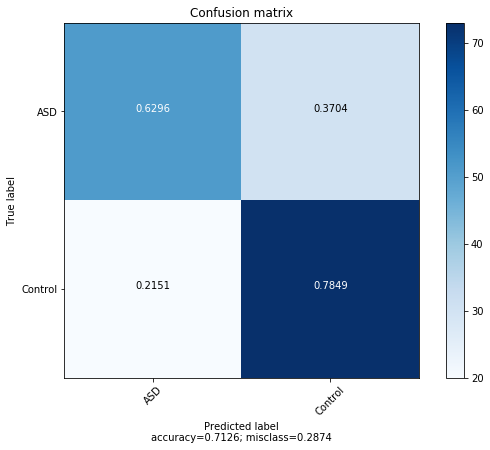

Best score: 0.6857142857142857
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('svc', SVC(C=145, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00011119999999999999,
  kernel='rbf', max_iter=-1, probability=False, random_state=9,
  shrinking=True, tol=0.001, verbose=False))])
Best params: {'svc__C': 145, 'svc__gamma': 0.00011119999999999999}


In [14]:
print('Test accuracy: {:.2f}%'.format(100*svc_gdcv_ref.score(X_te, y_te)))
models_acc['SVC refined'] = 100*svc_gdcv_ref.score(X_te, y_te)

y_pred = svc_gdcv_ref.predict(X_te)

report = classification_report(y_true=y_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', svc_gdcv_ref.best_score_)
print('Best estimator:', svc_gdcv_ref.best_estimator_)
print('Best params:', svc_gdcv_ref.best_params_)

# C set to 14 with 71.84%

# Lets create models with the confounds time series

# Load the time series with confounds

In [15]:
# let's load the dataset created

with np.load('fMRI_time_series_confounds.npz', allow_pickle=True) as npz_file:
    data_conf = dict(npz_file.items())
    
print('Data loaded')
print('It is a dictionary with keys:', list(data_conf.keys()))

X_c = data_conf['matrix']
print('X shape:', X_c.shape)

y_c = data_conf['targets']
print('y shape:', y_c.shape)

Data loaded
It is a dictionary with keys: ['matrix', 'targets']
X shape: (870,)
y shape: (870,)


In [16]:
from sklearn.model_selection import train_test_split

# Create X and y arrays for my analysis

X_c_tr, X_c_te, y_c_tr, y_c_te = train_test_split(X_c, y_c, test_size=0.20, stratify=y_c, random_state = 9)

print('X train:', X_c_tr.shape)
print('X test:', X_c_te.shape)
print('y train:', y_c_tr.shape)
print('y test:', y_c_te.shape)

print('ASD in the test data:', (y_c_te == 1).sum())
print('Control in the test data:', (y_c_te == 2).sum())

X train: (696,)
X test: (174,)
y train: (696,)
y test: (174,)
ASD in the test data: 81
Control in the test data: 93


## Create a baseline to evaluate my models

In [17]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it
dummy.fit(None, y_c_tr)

# Compute test accuracy
baseline_accuracy = dummy.score(None, y_c_te)
print('Accuracy: {:.2f}'.format(baseline_accuracy))

Accuracy: 0.53


## LinearSVC model

* Connectivity : type of matrix connectivity
* Standard Scaler 
* C

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
# import warnings filter
from warnings import simplefilter
# ignore all fuature warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nilearn.connectome import ConnectivityMeasure


linear_svc = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True)),
    ('scaler', StandardScaler()),
    ('l_svc', LinearSVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

param_grid = {
    'connectivity__kind':['correlation', 'partial correlation', 'tangent'],
    'scaler': [None, StandardScaler()],
    'l_svc__C':[0.0001, 0.001, 0.01, 0.05, 1, 10],
}

lin_svc = GridSearchCV(linear_svc, param_grid, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

lin_svc.fit(X_c_tr, y_c_tr);

lin_svc_results = pd.DataFrame({
    'connectivity': lin_svc.cv_results_['param_connectivity__kind'],
    'scale': lin_svc.cv_results_['param_scaler'],
    'C': lin_svc.cv_results_['param_l_svc__C'],
    'mean_tr': lin_svc.cv_results_['mean_train_score'],
    'mean_te': lin_svc.cv_results_['mean_test_score'],
    'std_te': lin_svc.cv_results_['std_test_score']
})

lin_svc_results.sort_values(by='mean_te', ascending=False).head(5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.1min finished


,connectivity,scale,C,mean_tr,mean_te,std_te
28,tangent,None,0.01,0.943131,0.662857,0.043892
30,tangent,None,0.05,0.998722,0.657143,0.045175
16,partial correlation,None,0.01,0.906070,0.651429,0.014569
4,correlation,None,0.01,0.905431,0.648571,0.071486
13,partial correlation,"StandardScaler(copy=True, with_mean=True, with...",0.0001,0.965815,0.642857,0.032576


Test accuracy: 67.82%
              precision    recall  f1-score   support

           1       0.67      0.60      0.64        81
           2       0.68      0.74      0.71        93

   micro avg       0.68      0.68      0.68       174
   macro avg       0.68      0.67      0.67       174
weighted avg       0.68      0.68      0.68       174



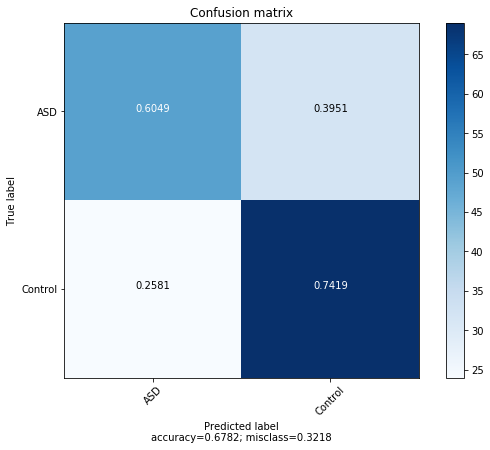

Best score: 0.6628571428571428
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('scaler', None), ('l_svc', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=9, tol=0.0001,
     verbose=0))])
Best params: {'connectivity__kind': 'tangent', 'l_svc__C': 0.01, 'scaler': None}


In [19]:
print('Test accuracy: {:.2f}%'.format(100*lin_svc.score(X_c_te, y_c_te)))

y_pred = lin_svc.predict(X_c_te)

report = classification_report(y_true=y_c_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_c_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', lin_svc.best_score_)
print('Best estimator:', lin_svc.best_estimator_)
print('Best params:', lin_svc.best_params_)

In [20]:
# Refine
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
# import warnings filter
from warnings import simplefilter
# ignore all fuature warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nilearn.connectome import ConnectivityMeasure


linear_svc_r = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True, kind='tangent')),
#     ('scaler', StandardScaler()),
    ('l_svc', LinearSVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

grid_refined = {
    'l_svc__C':np.linspace(0.001, 0.05, 20),
}

lin_svc_ref = GridSearchCV(linear_svc_r, grid_refined, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

lin_svc_ref.fit(X_c_tr, y_c_tr);

lin_svc_results = pd.DataFrame({
#     'connectivity': lin_svc.cv_results_['param_connectivity__kind'],
#     'scale': lin_svc.cv_results_['param_scaler'],
    'C': lin_svc_ref.cv_results_['param_l_svc__C'],
    'mean_tr': lin_svc_ref.cv_results_['mean_train_score'],
    'mean_te': lin_svc_ref.cv_results_['mean_test_score'],
    'std_te': lin_svc_ref.cv_results_['std_test_score']
})


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


Test accuracy: 68.39%
              precision    recall  f1-score   support

           1       0.67      0.63      0.65        81
           2       0.69      0.73      0.71        93

   micro avg       0.68      0.68      0.68       174
   macro avg       0.68      0.68      0.68       174
weighted avg       0.68      0.68      0.68       174



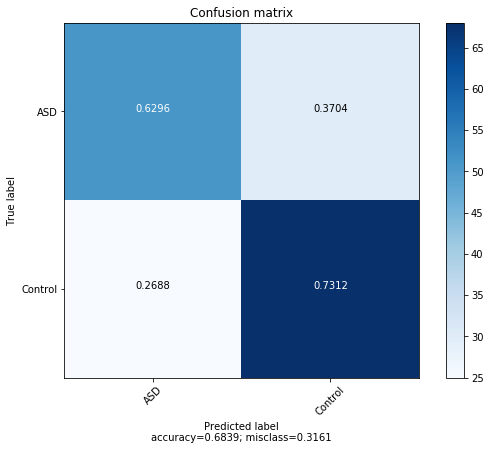

Best score: 0.6714285714285714
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('l_svc', LinearSVC(C=0.01905263157894737, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=9,
     tol=0.0001, verbose=0))])
Best params: {'l_svc__C': 0.01905263157894737}


In [21]:
print('Test accuracy: {:.2f}%'.format(100*lin_svc_ref.score(X_c_te, y_c_te)))
models_acc['Linear SVC confounds'] = 100*lin_svc_ref.score(X_c_te, y_c_te)

y_pred = lin_svc_ref.predict(X_c_te)

report = classification_report(y_true=y_c_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_c_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', lin_svc_ref.best_score_)
print('Best estimator:', lin_svc_ref.best_estimator_)
print('Best params:', lin_svc_ref.best_params_)

# SVC estimator

* Connectivity : type of matrix connectivity
* Standard Scaler 
* Kernel : rbf/linear
* C
* Gamma

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings

SVC = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True)),
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=9))
])

cv = StratifiedShuffleSplit(n_splits=3, random_state=0)

param_grid = {
    'connectivity__kind':['correlation', 'tangent'],
    'scaler': [None, StandardScaler()],
    'svc__C':np.linspace(0.001, 100, 5),
    'svc__gamma': np.linspace(0.0001, 100, 5),
    'svc__kernel':['rbf', 'linear']
}

svc_gdcv = GridSearchCV(SVC, param_grid, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

svc_gdcv.fit(X_c_tr, y_c_tr);

svc_results = pd.DataFrame({
    'connectivity': svc_gdcv.cv_results_['param_connectivity__kind'],
    'scale': svc_gdcv.cv_results_['param_scaler'],
    'kernel':svc_gdcv.cv_results_['param_svc__kernel'],
    'C': svc_gdcv.cv_results_['param_svc__C'],
    'gamma': svc_gdcv.cv_results_['param_svc__gamma'],
    'mean_tr': svc_gdcv.cv_results_['mean_train_score'],
    'mean_te': svc_gdcv.cv_results_['mean_test_score'],
    'std_te': svc_gdcv.cv_results_['std_test_score']
})

svc_results.sort_values(by='mean_te', ascending=False).head(5)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 17.4min finished


,connectivity,scale,kernel,C,gamma,mean_tr,mean_te,std_te
140,tangent,None,rbf,100,0.0001,0.813099,0.638095,0.029354
33,correlation,None,linear,75.0002,25.0001,1.000000,0.623810,0.013469
19,correlation,None,linear,25.0008,100,1.000000,0.623810,0.013469
21,correlation,None,linear,50.0005,0.0001,1.000000,0.623810,0.013469
23,correlation,None,linear,50.0005,25.0001,1.000000,0.623810,0.013469


Test accuracy: 64.37%
              precision    recall  f1-score   support

           1       0.67      0.46      0.54        81
           2       0.63      0.81      0.71        93

   micro avg       0.64      0.64      0.64       174
   macro avg       0.65      0.63      0.63       174
weighted avg       0.65      0.64      0.63       174



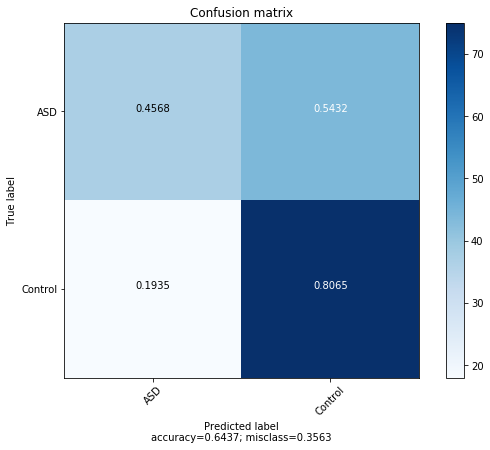

Best score: 0.638095238095238
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('scaler', None), ('svc', SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=9, shrinking=True,
  tol=0.001, verbose=False))])
Best params: {'connectivity__kind': 'tangent', 'scaler': None, 'svc__C': 100.0, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [23]:
print('Test accuracy: {:.2f}%'.format(100*svc_gdcv.score(X_c_te, y_c_te)))

y_pred = svc_gdcv.predict(X_c_te)

report = classification_report(y_true=y_c_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_c_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', svc_gdcv.best_score_)
print('Best estimator:', svc_gdcv.best_estimator_)
print('Best params:', svc_gdcv.best_params_)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings

SVC_ref = Pipeline([
    ('connectivity', ConnectivityMeasure(vectorize=True, 
                                        kind='tangent')),
    ('svc', SVC(random_state=9, 
               kernel='rbf'))
])

cv = StratifiedShuffleSplit(n_splits=5, random_state=0)

grid_refined = {
    'svc__C':np.arange(90, 140, 5),
    'svc__gamma': np.linspace(0.000001, 0.0005, 10),
}

svc_gdcv_ref = GridSearchCV(SVC_ref, grid_refined, cv=cv, n_jobs=-1, verbose=1, return_train_score=True)

svc_gdcv_ref.fit(X_c_tr, y_c_tr);

svc_results_refined = pd.DataFrame({
    'C': svc_gdcv_ref.cv_results_['param_svc__C'],
    'gamma': svc_gdcv_ref.cv_results_['param_svc__gamma'],
    'mean_tr': svc_gdcv_ref.cv_results_['mean_train_score'],
    'mean_te': svc_gdcv_ref.cv_results_['mean_test_score'],
    'std_te': svc_gdcv_ref.cv_results_['std_test_score']
})

svc_results_refined.sort_values(by='mean_te', ascending=False).head(5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.5min finished


,C,gamma,mean_tr,mean_te,std_te
35,105,0.000278222,0.955272,0.688571,0.033074
6,90,0.000333667,0.956869,0.685714,0.033806
94,135,0.000222778,0.956869,0.685714,0.033806
15,95,0.000278222,0.947284,0.685714,0.040406
45,110,0.000278222,0.957827,0.682857,0.035456


Test accuracy: 71.26%
              precision    recall  f1-score   support

           1       0.71      0.65      0.68        81
           2       0.72      0.76      0.74        93

   micro avg       0.71      0.71      0.71       174
   macro avg       0.71      0.71      0.71       174
weighted avg       0.71      0.71      0.71       174



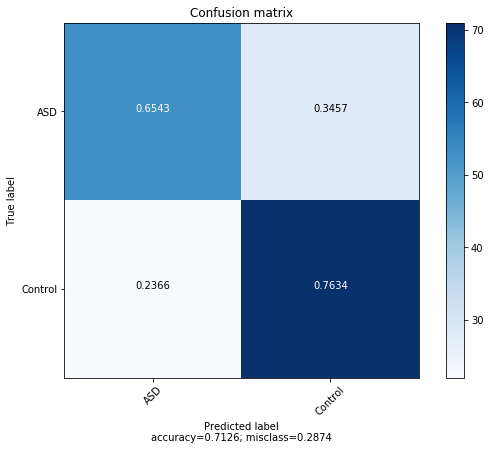

Best score: 0.6885714285714286
Best estimator: Pipeline(memory=None,
     steps=[('connectivity', ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False, block_size=1000, store_precision=False),
          discard_diagonal=False, kind='tangent', vectorize=True)), ('svc', SVC(C=105, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00027822222222222224,
  kernel='rbf', max_iter=-1, probability=False, random_state=9,
  shrinking=True, tol=0.001, verbose=False))])
Best params: {'svc__C': 105, 'svc__gamma': 0.00027822222222222224}


In [25]:
print('Test accuracy: {:.2f}%'.format(100*svc_gdcv_ref.score(X_c_te, y_c_te)))
models_acc['SVC confounds'] = 100*svc_gdcv_ref.score(X_c_te, y_c_te)

y_pred = svc_gdcv_ref.predict(X_c_te)

report = classification_report(y_true=y_c_te, y_pred=y_pred)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_true=y_c_te, y_pred=y_pred)

plot_confusion_matrix(matrix, ['ASD', 'Control'])

print('Best score:', svc_gdcv_ref.best_score_)
print('Best estimator:', svc_gdcv_ref.best_estimator_)
print('Best params:', svc_gdcv_ref.best_params_)

<br>
<br>

--- 
--- 

# 5. Conclusion

In [26]:
models_df = pd.Series(models_acc).to_frame('Models')
models_df.sort_values('Models', ascending=False)

,Models
Linear SVC,72.988506
SVC refined,71.264368
SVC confounds,71.264368
Linear SVC confounds,68.390805
baseline,53.448276


In [27]:
models_df.to_csv('fMRI_models.csv', index=False, encoding='utf-8')

All the models have a hard time at classifying ASD with the fMRI data.

The smallest change in parameter (especially the random seed) makes the results change drastically. Despite the fact that these models correctly classify autism with 72 percent of accuracy, I believe that these results are not very reliable. 
We can see from the confusion matrix and the classification report that most models classify more easily controls than ASD. The only models that classify more or less the same for both groups is our best with 72.99% of accuracy. 

I believe the accuracy could be improved with more data processing and other data manipulations:
* Looking at sites differences and controling for those differences; 
* preprocessing the data ourselves;
* maybe using a better atlas for this dataset;
* finding a solution for the matrix that looks like confounds, I am still unsure about the fact that they are almost no negative connection for example.